Shadeeb Hossain

ID : sh7492

# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo2_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading Tensorflow

Before starting this lab, you will need to install [Tensorflow](https://www.tensorflow.org/install/).  If you are using [Google colaboratory](https://colab.research.google.com), Tensorflow is already installed.  Run the following command to ensure Tensorflow is installed.

In [ ]:
import tensorflow as tf

Then, load the other packages.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification.

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [ ]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [ ]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO 1:  Load the file from url and save it in a file under the name fn
import requests
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/001.wav"

response = requests.get(url)




Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [ ]:
# TODO 2
import librosa

# Specify the filename of the downloaded audio file
fn = "soprano_saxophone.wav"

# Load the audio file using librosa
y, sr = librosa.load(fn)

# Print the sample rate
print(f"Sample Rate,sr: {sr}")


# Calculate the number of samples
num_samples = len(y)

# Print the result
print(f"Number of Samples,y: {num_samples}")

# y, sr = ...

Sample Rate,sr: 22050
Number of Samples,y: 338485


Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

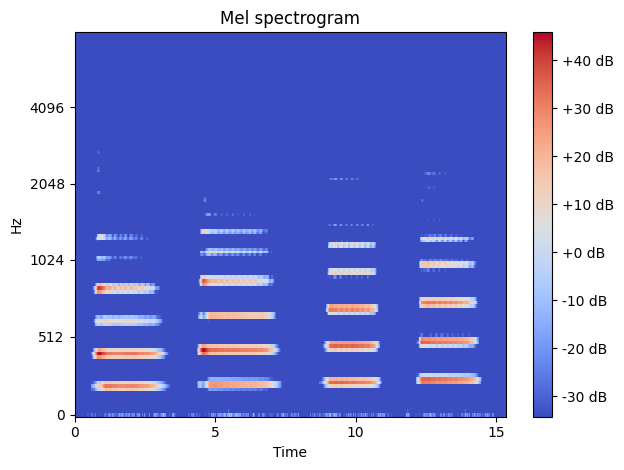

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [ ]:
data_dir = 'instrument_dataset/'
Xtr = np.load('uiowa_train_data.npy')
ytr = np.load('uiowa_train_labels.npy')
Xts = np.load('uiowa_test_data.npy')
yts = np.load('uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [ ]:
# TODO 3
import numpy as np

num_training_samples = Xtr.shape[0]
num_test_samples = Xts.shape[0]
num_features = Xtr.shape[1]
num_classes = len(np.unique(ytr))
print(f"Number of Training Samples: {num_training_samples}")
print(f"Number of Test Samples: {num_test_samples}")
print(f"Number of Features for Each Sample: {num_features}")
print(f"Number of Classes (Instruments): {num_classes}")


Number of Training Samples: 66247
Number of Test Samples: 14904
Number of Features for Each Sample: 120
Number of Classes (Instruments): 10


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [ ]:
# TODO 4: Scale the training and test matrices
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtr_scale = scaler.fit_transform(Xtr)
Xts_scale = scaler.transform(Xts)
mean_values = scaler.mean_
std_dev_values = scaler.scale_
for feature_idx, (mean, std_dev) in enumerate(zip(mean_values, std_dev_values)):
    print(f"Feature {feature_idx + 1}: Mean = {mean}, Std Dev = {std_dev}")

# Xtr_scale = ...
# Xts_scale = ...

Feature 1: Mean = 0.000311396769229421, Std Dev = 0.00040639504064489125
Feature 2: Mean = 0.0012518733210245118, Std Dev = 0.0016359706486663481
Feature 3: Mean = 0.005739698137129118, Std Dev = 0.007470869381074944
Feature 4: Mean = 0.003683702080221069, Std Dev = 0.0047717254023178736
Feature 5: Mean = 0.00035321099061597793, Std Dev = 0.000649247639861341
Feature 6: Mean = 0.0008786922331258713, Std Dev = 0.0016046035484330301
Feature 7: Mean = 0.0017007975004097412, Std Dev = 0.0034562010180033
Feature 8: Mean = 0.00182722101337871, Std Dev = 0.003237513938224512
Feature 9: Mean = 0.0015340753467888112, Std Dev = 0.0022034658107452413
Feature 10: Mean = 0.00111329502869382, Std Dev = 0.0014700238157937357
Feature 11: Mean = 0.0002936499993631473, Std Dev = 0.0003513330150665423
Feature 12: Mean = 0.0002758750291924995, Std Dev = 0.0003160420057477934
Feature 13: Mean = 0.0003151550051505951, Std Dev = 0.0004078948575726842
Feature 14: Mean = 0.0012610805276376251, Std Dev = 0.0016

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation
* select the input and output shapes correctly
* print the model summary

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K


In [ ]:
# TODO 5 clear session
import tensorflow as tf
from tensorflow.keras import layers, models
tf.keras.backend.clear_session()


In [ ]:
# TODO 6: construct the model
nh = 256
model = models.Sequential()
model.add(layers.Dense(nh, activation='sigmoid', input_shape=(num_features,)))
model.add(layers.Dense(num_classes, activation='softmax'))


In [ ]:
# TODO 7:  Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               30976     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 33546 (131.04 KB)
Trainable params: 33546 (131.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [ ]:
# TODO 8
from tensorflow.keras import optimizers
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # Assuming a classification problem
              metrics=['accuracy'])
model.summary()

# opt = ...
# model.compile(...)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               30976     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 33546 (131.04 KB)
Trainable params: 33546 (131.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  Use a batch size of 100.  Your final accuracy should be >99%.

In [ ]:
# TODO 9
from tensorflow.keras.callbacks import Callback

tf.keras.backend.clear_session()
nh = 256
model = models.Sequential()
model.add(layers.Dense(nh, activation='sigmoid', input_shape=(num_features,)))
model.add(layers.Dense(num_classes, activation='softmax'))

# Create an instance of the Adam optimizer with a learning rate of 0.001
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create an instance of your custom callback class
my_callback_instance = MyCustomCallback(target_accuracy=0.99)

# Fit the model
history = model.fit(
    Xtr_scale, ytr,
    epochs=10,
    batch_size=100,
    validation_data=(Xts_scale, yts),
    callbacks=[my_callback_instance]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(Xts_scale, yts)

# Print the final accuracy
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
663/663 [==============================] - 4s 4ms/step - loss: 0.3612 - accuracy: 0.9020 - val_loss: 0.1729 - val_accuracy: 0.9621
Epoch 2/10
663/663 [==============================] - 2s 4ms/step - loss: 0.1019 - accuracy: 0.9752 - val_loss: 0.0950 - val_accuracy: 0.9781
Epoch 3/10
663/663 [==============================] - 3s 4ms/step - loss: 0.0597 - accuracy: 0.9858 - val_loss: 0.0637 - val_accuracy: 0.9847
Epoch 4/10
663/663 [==============================] - 3s 5ms/step - loss: 0.0422 - accuracy: 0.9897 - val_loss: 0.0492 - val_accuracy: 0.9865
Epoch 5/10
663/663 [==============================] - 2s 4ms/step - loss: 0.0319 - accuracy: 0.9919 - val_loss: 0.0404 - val_accuracy: 0.9899
Epoch 6/10
663/663 [==============================] - 2s 4ms/step - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.0482 - val_accuracy: 0.9845
Epoch 7/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0208 - accuracy: 0.9945 - val_loss: 0.0363 - val_accuracy: 0.9890
Epoch 

Plot the validation accuracy saved in `hist.history` dictionary. This gives one accuracy value per epoch.  You should see that the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

Epoch 1/10
652/663 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9964
Reached target accuracy (99.00%), stopping training!
663/663 [==============================] - 3s 5ms/step - loss: 0.0145 - accuracy: 0.9963 - val_loss: 0.0233 - val_accuracy: 0.9921


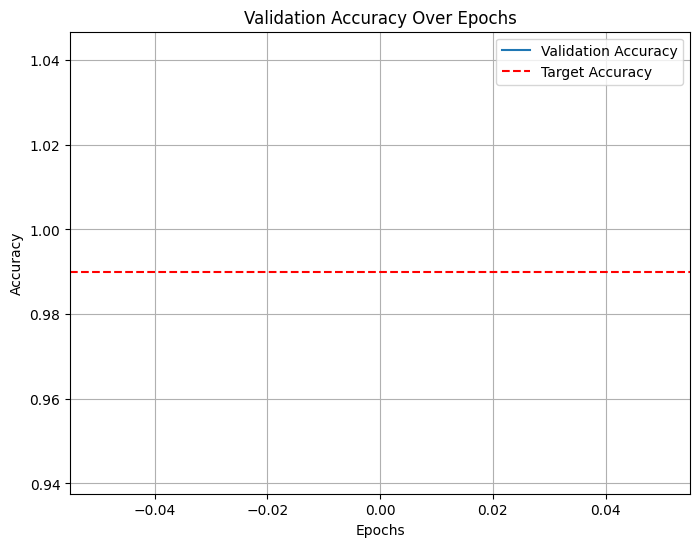

In [ ]:
# TODO 10
import matplotlib.pyplot as plt
history = model.fit(
    Xtr_scale, ytr,
    epochs=10,
    batch_size=100,
    validation_data=(Xts_scale, yts),
    callbacks=[my_callback_instance]
)
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=0.99, color='r', linestyle='--', label='Target Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Plot the loss values saved in the `hist.history` dictionary.  You should see that the loss is steadily decreasing.  Use the `semilogy` plot.

Epoch 1/10
661/663 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9968
Reached target accuracy (99.00%), stopping training!
663/663 [==============================] - 4s 6ms/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 0.0231 - val_accuracy: 0.9921


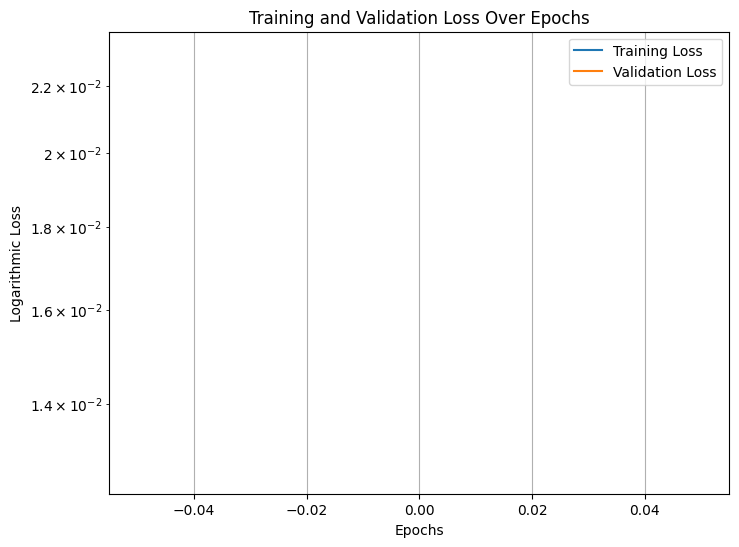

In [ ]:
# TODO 11
import matplotlib.pyplot as plt
history = model.fit(
    Xtr_scale, ytr,
    epochs=10,
    batch_size=100,
    validation_data=(Xts_scale, yts),
    callbacks=[my_callback_instance]
)
plt.figure(figsize=(8, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Logarithmic Loss')
plt.legend()
plt.grid(True)
plt.show()


## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model for 20 epochs
* save the accuracy and losses

In [ ]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []

# TODO 12
# for lr in rate:
#    ...


Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.

In [ ]:
# TODO 13